In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as fcnal
from sklearn.pipeline import Pipeline
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import OrderedDict
import math


import warnings
warnings.filterwarnings("ignore")

In [0]:
import torch
import torch.nn as nn


class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x


In [0]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class BinActive(torch.autograd.Function):
    '''
    Binarize the input activations and calculate the mean across channel dimension.
    '''
    def forward(self, input):
        self.save_for_backward(input)
        size = input.size()
        mean = torch.mean(input.abs(), 1, keepdim=True)
        input = input.sign()
        return input, mean

    def backward(self, grad_output, grad_output_mean):
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input.ge(1)] = 0
        grad_input[input.le(-1)] = 0
        return grad_input

class BinConv2d(nn.Module):
    def __init__(self, input_channels, output_channels,
            kernel_size=-1, stride=-1, padding=-1, dropout=0):
        super(BinConv2d, self).__init__()
        self.layer_type = 'BinConv2d'
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dropout_ratio = 0
        dropout=0
        self.bn = nn.BatchNorm2d(input_channels, eps=1e-4, momentum=0.1, affine=True)
        self.bn.weight.data = self.bn.weight.data.zero_().add(1.0)
        if dropout!=0:
            self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv2d(input_channels, output_channels,
                kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.bn(x)
        x, mean = BinActive()(x)
        x = self.conv(x)
        x = self.relu(x)
        return x

class BinNet(nn.Module):

    def __init__(self, num_classes=10):
        super(BinNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=2, padding=2),
            nn.BatchNorm2d(64, eps=1e-4, momentum=0.1, affine=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            BinConv2d(64, 192, stride=1, kernel_size=5, padding=2),
            nn.BatchNorm2d(192, eps=1e-4, momentum=0.1, affine=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            BinConv2d(192, 384, stride=1, kernel_size=3, padding=2),
            nn.BatchNorm2d(384, eps=1e-4, momentum=0.1, affine=False),
            nn.ReLU(inplace=True),
            BinConv2d(384, 256, stride=1, kernel_size=3, padding=2),
            nn.BatchNorm2d(256, eps=1e-4, momentum=0.1, affine=False),
            nn.ReLU(inplace=True),
            BinConv2d(256, 256, stride=1, kernel_size=3, padding=2),
            nn.BatchNorm2d(256, eps=1e-4, momentum=0.1, affine=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [0]:
import torch.nn as nn
import numpy

class BinOp():
    def __init__(self, model):
        # count the number of Conv2d
        count_Conv2d = 0
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                count_Conv2d = count_Conv2d + 1

        start_range = 1
        end_range = count_Conv2d-2
        self.bin_range = numpy.linspace(start_range,
                end_range, end_range-start_range+1)\
                        .astype('int').tolist()
        self.num_of_params = len(self.bin_range)
        self.saved_params = []
        self.target_params = []
        self.target_modules = []
        index = -1
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                index = index + 1
                if index in self.bin_range:
                    tmp = m.weight.data.clone()
                    self.saved_params.append(tmp)
                    self.target_modules.append(m.weight)

    def binarization(self):
        self.meancenterConvParams()
        self.clampConvParams()
        self.save_params()
        self.binarizeConvParams()

    def meancenterConvParams(self):
        for index in range(self.num_of_params):
            s = self.target_modules[index].data.size()
            negMean = self.target_modules[index].data.mean(1, keepdim=True).\
                    mul(-1).expand_as(self.target_modules[index].data)
            self.target_modules[index].data = self.target_modules[index].data.add(negMean)

    def clampConvParams(self):
        for index in range(self.num_of_params):
            self.target_modules[index].data = \
                    self.target_modules[index].data.clamp(-1.0, 1.0)

    def save_params(self):
        for index in range(self.num_of_params):
            self.saved_params[index].copy_(self.target_modules[index].data)

    def binarizeConvParams(self):
        for index in range(self.num_of_params):
            n = self.target_modules[index].data[0].nelement()
            s = self.target_modules[index].data.size()
            m = self.target_modules[index].data.norm(1, 3, keepdim=True)\
                    .sum(2, keepdim=True).sum(1, keepdim=True).div(n)
            self.target_modules[index].data = \
                    self.target_modules[index].data.sign().mul(m.expand(s))

    def restore(self):
        for index in range(self.num_of_params):
            self.target_modules[index].data.copy_(self.saved_params[index])

    def updateBinaryGradWeight(self):
        for index in range(self.num_of_params):
            weight = self.target_modules[index].data
            n = weight[0].nelement()
            s = weight.size()
            m = weight.norm(1, 3, keepdim=True)\
                    .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)
            m[weight.lt(-1.0)] = 0 
            m[weight.gt(1.0)] = 0
            # m = m.add(1.0/n).mul(1.0-1.0/s[1]).mul(n)
            # self.target_modules[index].grad.data = \
            #         self.target_modules[index].grad.data.mul(m)
            m = m.mul(self.target_modules[index].grad.data)
            m_add = weight.sign().mul(self.target_modules[index].grad.data)
            m_add = m_add.sum(3, keepdim=True)\
                    .sum(2, keepdim=True).sum(1, keepdim=True).div(n).expand(s)
            m_add = m_add.mul(weight.sign())
            self.target_modules[index].grad.data = m.add(m_add).mul(1.0-1.0/s[1]).mul(n)

In [5]:
batch_size=128
lr=1e-3
log_interval=100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [0]:
def train(model, epochs):
    model.train()
    for epoch in range(epochs):

        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            #loss = nn.NLLLoss(output,target)
            loss.backward()

            optimizer.step()
            if batch_idx % 100 == 0:
                done = batch_idx * len(data)
                percentage = 100. * batch_idx / len(trainloader)
                print(f'Train Epoch: {epoch} [{done:5}/{len(trainloader.dataset)} ({percentage:3.0f}%)]  Loss: {loss.item():.6f}')

        test(model, trainloader)
        test(model, testloader)


def test(model, loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            #test_loss += nn.NLLLoss(output, target).item()
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({accuracy:.2f}%)')
    return accuracy






def distill_training(teacher=None, learner=None, data_loader=None,
                     test_loader=None, optimizer=None,
                     criterion=None, n_epochs=0):
    """
    :param teacher: network to provide soft labels in training
    :param learner: network to distill knowledge into
    :param data_loader: data loader for training data set
    :param test_loaderL data loader for validation data
    :param optimizer: optimizer for training
    :param criterion: objective function, should allow for soft labels.
                      We suggest softCrossEntropy
    :param n_epochs: epochs for training
    :param verbose: verbose == True will print loss at each batch
    :return: None, teacher model is trained in place
    """
    losses = []
    for epoch in range(n_epochs):
        teacher.eval()
        learner.train()
        print("[{}/{}] ".format(epoch, n_epochs))
        for i, batch in enumerate(data_loader):
            with torch.set_grad_enabled(False):
                data, labels = batch
                data, labels = data.to(device), labels.to(device)
                soft_lables = teacher(data)

            with torch.set_grad_enabled(True):
                optimizer.zero_grad()
                outputs = learner(data)
                loss = criterion(outputs, torch.max(soft_lables.type(torch.cuda.LongTensor), 1)[1])#, labels)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            if i%100==0:
                done= i * len(data)
                percentage = 100. * i / len(data_loader)
                print(f'Train Epoch: {epoch} [{done:5}/{len(data_loader.dataset)} ({percentage:3.0f}%)]  Loss: {loss.item():.6f}')

        # evaluate performance on testset at the end of each epoch
       

        train_acc = test(learner, data_loader)
        test_acc = test(learner, test_loader)
    return train_acc, test_acc



In [7]:
# Model
print('==> Building model..')
teacher = Net()
teacher = teacher.to(device)
teacher = torch.nn.DataParallel(teacher)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0)
optimizer = optim.Adam(teacher.parameters(), lr=1e-3, weight_decay=0.0000)

train(teacher,  150)



==> Building model..
Train Epoch: 0 [    0/50000 (  0%)]  Loss: 2.303069
Train Epoch: 0 [12800/50000 ( 26%)]  Loss: 1.680549
Train Epoch: 0 [25600/50000 ( 51%)]  Loss: 1.618903
Train Epoch: 0 [38400/50000 ( 77%)]  Loss: 1.736200
Test set: Average loss: 0.0123, Accuracy: 20597/50000 (41.19%)
Test set: Average loss: 0.0151, Accuracy: 4328/10000 (43.28%)
Train Epoch: 1 [    0/50000 (  0%)]  Loss: 1.531754
Train Epoch: 1 [12800/50000 ( 26%)]  Loss: 1.524465
Train Epoch: 1 [25600/50000 ( 51%)]  Loss: 1.288069
Train Epoch: 1 [38400/50000 ( 77%)]  Loss: 1.166009
Test set: Average loss: 0.0105, Accuracy: 25661/50000 (51.32%)
Test set: Average loss: 0.0128, Accuracy: 5425/10000 (54.25%)
Train Epoch: 2 [    0/50000 (  0%)]  Loss: 1.365436
Train Epoch: 2 [12800/50000 ( 26%)]  Loss: 1.369176
Train Epoch: 2 [25600/50000 ( 51%)]  Loss: 1.345633
Train Epoch: 2 [38400/50000 ( 77%)]  Loss: 1.252254
Test set: Average loss: 0.0090, Accuracy: 29241/50000 (58.48%)
Test set: Average loss: 0.0112, Accuracy: 

KeyboardInterrupt: ignored

tensor([[3]], device='cuda:0')
tensor([[3]], device='cuda:0')
[0.06327114254236221, 0.025417674332857132, 0.011714407242834568, 0.5831579566001892, 0.04046289622783661, 0.02152826450765133, 0.00799587182700634, 0.1768314242362976, 0.021124042570590973, 0.04849636182188988]
[0.0010145490523427725, 0.00030558116850443184, 0.0008154626120813191, 0.9787409901618958, 0.00029880856163799763, 0.010064681060612202, 0.00022722511494066566, 0.007986118085682392, 0.00020130971097387373, 0.00034515938023105264]


<BarContainer object of 10 artists>

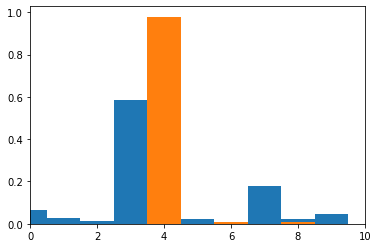

In [21]:
temptrainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1, shuffle=False)
temptestloader = torch.utils.data.DataLoader(dataset=testset, batch_size=1, shuffle=False)

train=[]
for data, target in temptrainloader:
  data, target = data.to(device), target.to(device)
  if target==3:
    out=teacher(data)
    out=F.softmax(out)
    
    for i in out:
      for j in i:
        train.append(j.item())
    #print(out)
    pred = out.data.max(1, keepdim=True)[1]
    print(pred)
    break

test=[]
for data, target in temptestloader:
  data, target = data.to(device), target.to(device)
  if target==3:
    out=teacher(data)
    out=F.softmax(out)
    
    for i in out:
      for j in i:
        test.append(j.item())
    #print(out)
    pred = out.data.max(1, keepdim=True)[1]
    print(pred)
    break

#print(train)
#print(test)




print(train)
print(test)

import matplotlib.pyplot as plt

ind = np.arange(len(train))
width = 1     
plt.xlim(right=10) 
plt.bar(ind, train, width, label='train')
plt.bar(ind + width, test, width,label='test')

In [26]:
learner = BinNet()

learner.cuda()
#learner = torch.nn.DataParallel(learner, device_ids=range(torch.cuda.device_count()))


optimizer = optim.Adam(learner.parameters(), lr=1e-3,weight_decay=0.0000)
criterion = nn.CrossEntropyLoss()

# define the binarization operator
bin_op = BinOp(learner)

distill_training(teacher, learner, trainloader, testloader, optimizer, criterion, 100)

[0/100] 
Train Epoch: 0 [    0/50000 (  0%)]  Loss: 2.370922
Train Epoch: 0 [12800/50000 ( 26%)]  Loss: 2.000820
Train Epoch: 0 [25600/50000 ( 51%)]  Loss: 1.717410
Train Epoch: 0 [38400/50000 ( 77%)]  Loss: 1.755207


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0051e3b780>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0051e3b780>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Test set: Average loss: 0.0132, Accuracy: 17517/50000 (35.03%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0051e3b780>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0051e3b780>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/lib/p

Test set: Average loss: 0.0166, Accuracy: 3542/10000 (35.42%)
[1/100] 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0051e3b780>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0051e3b780>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 1 [    0/50000 (  0%)]  Loss: 1.847076


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 1 [12800/50000 ( 26%)]  Loss: 1.706652
Train Epoch: 1 [25600/50000 ( 51%)]  Loss: 1.549164
Train Epoch: 1 [38400/50000 ( 77%)]  Loss: 1.529888
Test set: Average loss: 0.0115, Accuracy: 22881/50000 (45.76%)
Test set: Average loss: 0.0144, Accuracy: 4680/10000 (46.80%)
[2/100] 
Train Epoch: 2 [    0/50000 (  0%)]  Loss: 1.246835
Train Epoch: 2 [12800/50000 ( 26%)]  Loss: 1.351807
Train Epoch: 2 [25600/50000 ( 51%)]  Loss: 1.254956
Train Epoch: 2 [38400/50000 ( 77%)]  Loss: 1.407531
Test set: Average loss: 0.0111, Accuracy: 25098/50000 (50.20%)
Test set: Average loss: 0.0144, Accuracy: 4972/10000 (49.72%)
[3/100] 
Train Epoch: 3 [    0/50000 (  0%)]  Loss: 1.475382
Train Epoch: 3 [12800/50000 ( 26%)]  Loss: 1.559021
Train Epoch: 3 [25600/50000 ( 51%)]  Loss: 1.318977
Train Epoch: 3 [38400/50000 ( 77%)]  Loss: 1.114582
Test set: Average loss: 0.0099, Accuracy: 27340/50000 (54.68%)
Test set: Average loss: 0.0128, Accuracy: 5424/10000 (54.24%)
[4/100] 
Train Epoch: 4 [    0/5000

KeyboardInterrupt: ignored

tensor([[3]], device='cuda:0')
tensor([[2]], device='cuda:0')
[0.07000309228897095, 0.017400363460183144, 0.019030457362532616, 0.29907193779945374, 0.10515590757131577, 0.22833536565303802, 0.04266407713294029, 0.04584269970655441, 0.11086355894804001, 0.061632607132196426]
[0.12253900617361069, 0.0015809950418770313, 0.27642616629600525, 0.07850959151983261, 0.2582301199436188, 0.14231687784194946, 0.004606064409017563, 0.10550655424594879, 0.005763859022408724, 0.004520699847489595]


<BarContainer object of 10 artists>

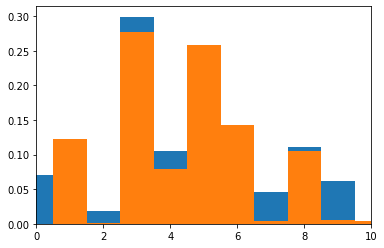

In [41]:
temptrainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1, shuffle=True)
temptestloader = torch.utils.data.DataLoader(dataset=testset, batch_size=1, shuffle=True)

train=[]
count=0
for data, target in temptrainloader:
  data, target = data.to(device), target.to(device)
  if target==3:
    out=learner(data)
    out=F.softmax(out)
    count+=1
    
    for i in out:
      for j in i:
        train.append(j.item())
    #print(out)
    pred = out.data.max(1, keepdim=True)[1]
    print(pred)
    break

test=[]
count2=0
for data, target in temptestloader:
  data, target = data.to(device), target.to(device)
  if target==3:
    out=learner(data)
    out=F.softmax(out)
    count2+=1
    
    for i in out:
      for j in i:
        test.append(j.item())
    #print(out)
    pred = out.data.max(1, keepdim=True)[1]
    print(pred)
    break

#print(train)
#print(test)




print(train)
print(test)

import matplotlib.pyplot as plt

ind = np.arange(len(train))
width = 1     
plt.xlim(right=10) 
plt.bar(ind, train, width, label='train')
plt.bar(ind + width, test, width,label='test')

In [0]:
def softmax_by_row(logits, T = 1.0):
    mx = np.max(logits, axis=-1, keepdims=True)
    exp = np.exp((logits - mx)/T)
    denominator = np.sum(exp, axis=-1, keepdims=True)
    return exp/denominator

def classifier_performance(model, train_loader, test_loader):

    output_train_benign = []
    train_label = []
    for num, data in enumerate(train_loader):
        images,labels = data
        image_tensor= images.to(device)
        img_variable = Variable(image_tensor, requires_grad=True)
        output = model.forward(img_variable)

        train_label.append(labels.numpy())
        output_train_benign.append(softmax_by_row(output.data.cpu().numpy(),T = 1))


    train_label = np.concatenate(train_label)
    output_train_benign=np.concatenate(output_train_benign)

    test_label = []
    output_test_benign = []

    for num, data in enumerate(test_loader):
        images,labels = data

        image_tensor= images.to(device)
        img_variable = Variable(image_tensor, requires_grad=True)

        output = model.forward(img_variable)

        test_label.append(labels.numpy())
        output_test_benign.append(softmax_by_row(output.data.cpu().numpy(),T = 1))


    test_label = np.concatenate(test_label)
    output_test_benign=np.concatenate(output_test_benign)


    train_acc1 = np.sum(np.argmax(output_train_benign,axis=1) == train_label.flatten())/len(train_label)
    test_acc1 = np.sum(np.argmax(output_test_benign,axis=1) == test_label.flatten())/len(test_label)

    print('Accuracy: ', (train_acc1, test_acc1))

    return output_train_benign, output_test_benign, train_label, test_label




def inference_via_confidence(confidence_mtx1, confidence_mtx2, label_vec1, label_vec2):
    
    #----------------First step: obtain confidence lists for both training dataset and test dataset--------------
    confidence1 = []
    confidence2 = []
    acc1 = 0
    acc2 = 0
    for num in range(confidence_mtx1.shape[0]):
        confidence1.append(confidence_mtx1[num,label_vec1[num]])
        if np.argmax(confidence_mtx1[num,:]) == label_vec1[num]:
            acc1 += 1
            
    for num in range(confidence_mtx2.shape[0]):
        confidence2.append(confidence_mtx2[num,label_vec2[num]])
        if np.argmax(confidence_mtx2[num,:]) == label_vec2[num]:
            acc2 += 1
    confidence1 = np.array(confidence1)
    confidence2 = np.array(confidence2)
    
    print('model accuracy for training and test-', (acc1/confidence_mtx1.shape[0], acc2/confidence_mtx2.shape[0]) )
    
    
    #sort_confidence = np.sort(confidence1)
    sort_confidence = np.sort(np.concatenate((confidence1, confidence2)))
    max_accuracy = 0.5
    best_precision = 0.5
    best_recall = 0.5
    for num in range(len(sort_confidence)):
        delta = sort_confidence[num]
        ratio1 = np.sum(confidence1>=delta)/confidence_mtx1.shape[0]
        ratio2 = np.sum(confidence2>=delta)/confidence_mtx2.shape[0]
        accuracy_now = 0.5*(ratio1+1-ratio2)
        if accuracy_now > max_accuracy:
            max_accuracy = accuracy_now
            best_precision = ratio1/(ratio1+ratio2)
            best_recall = ratio1
    print('membership inference accuracy is:', max_accuracy)
    return max_accuracy

In [0]:
from torch.autograd import Variable
import os
import numpy as np
import math 
import scipy
import sys  


output_train, output_test, train_label, test_label = classifier_performance(learner, trainloader, testloader)
inference_accuracy=inference_via_confidence(output_train, output_test, train_label, test_label)
print("Maximum Accuracy:",inference_accuracy)